In [97]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge


from sklearn.ensemble import GradientBoostingRegressor

In [83]:
housing_train = pd.read_csv("/Users/prgowtha/PycharmProjects/JupyterProject/Notebooks/kaggle test/house-prices-data/train.csv")
housing_test = pd.read_csv("/Users/prgowtha/PycharmProjects/JupyterProject/Notebooks/kaggle test/house-prices-data/test.csv")

for df in [housing_train, housing_test]:
    df["TotalSF"] = (
        df["TotalBsmtSF"] +
        df["1stFlrSF"] +
        df["2ndFlrSF"]
    )
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["HasGarage"] = (df["GarageCars"] > 0).astype(int)
    df["HasBasement"] = (df["TotalBsmtSF"] > 0).astype(int)

In [84]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 86 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [85]:
housing_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

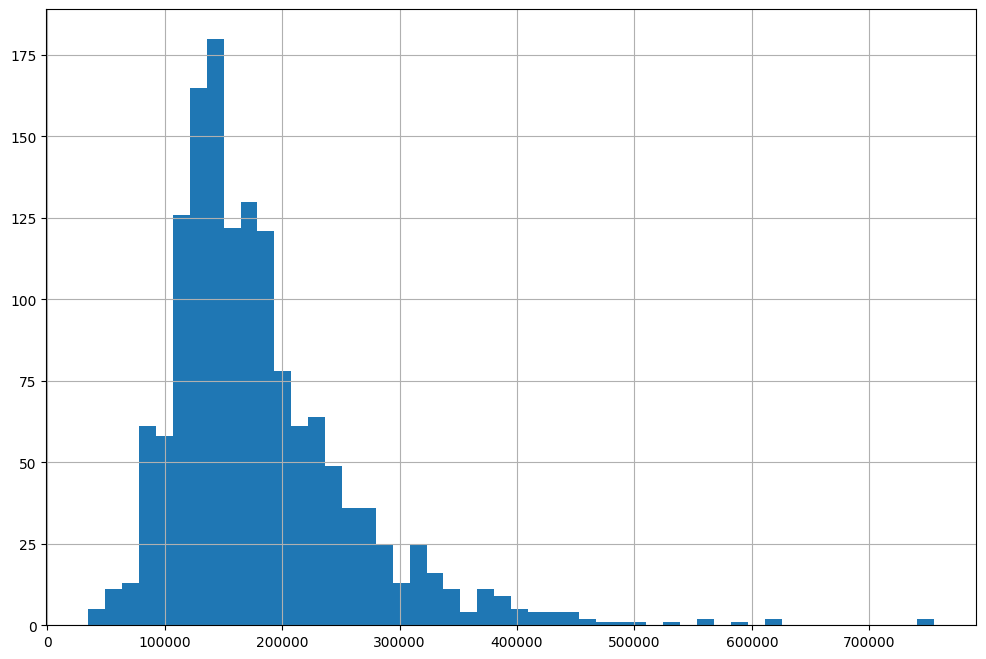

In [86]:
housing_train['SalePrice'].hist(bins=50,figsize=(12,8))
plt.show()

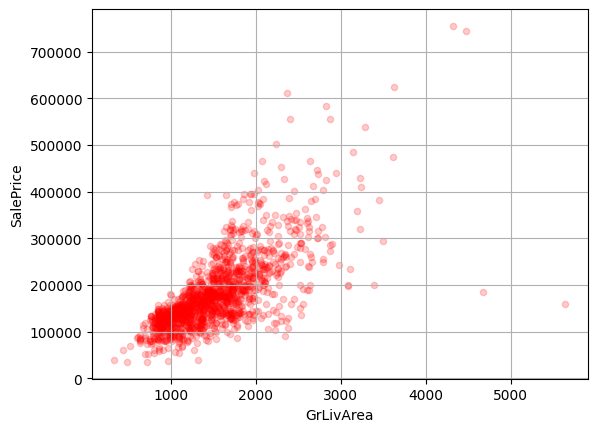

In [87]:
housing_train.plot(kind='scatter', x='GrLivArea', y='SalePrice',grid= True,alpha=0.2,c='red')
plt.show()

In [88]:
housing_train.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
ExterCond         0
ExterQual         0
Exterior2nd       0
Exterior1st       0
HasBasement       0
Length: 86, dtype: int64

In [89]:
missing = housing_train.isnull().sum()
missing[missing>0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

In [98]:
from sklearn.ensemble import RandomForestRegressor

X = housing_train.drop(columns=["SalePrice"])
y = housing_train["SalePrice"]

zero_fill_num_cols = [
    "GarageYrBlt", "GarageArea", "GarageCars",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
]

num_cols = X.select_dtypes(include=np.number).columns
median_num_cols = [c for c in num_cols if c not in zero_fill_num_cols]
cat_cols = X.select_dtypes(include="object").columns

numerical_median_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

numerical_zero_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])



preprocess = ColumnTransformer(
    transformers=[
        ("num_zero", numerical_zero_transformer, zero_fill_num_cols),
        ("num_median", numerical_median_transformer, median_num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

gbr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=3,
        random_state=42
    ))
])

ridge = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=10.0, random_state=42))
])



In [99]:
from sklearn.metrics import mean_squared_error

y_log = np.log1p(y)
# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, np.log1p(y), test_size=0.2, random_state=42
)

# Fit
rf.fit(X_train, y_train)
gbr.fit(X_train, y_train)
ridge.fit(X_train, y_train)

pred_rf = rf.predict(X_val)
pred_gbr = gbr.predict(X_val)
pred_ridge = ridge.predict(X_val)

# Weighted average (start simple)
pred_ens = 0.2 * pred_rf + 0.6 * pred_gbr + 0.2 * pred_ridge

rmse_log = np.sqrt(mean_squared_error(y_val, pred_ens))
print("Ensemble Validation RMSE (log space):", rmse_log)

Ensemble Validation RMSE (log space): 0.13169475791964042


In [100]:
rf.fit(X, y_log)
gbr.fit(X, y_log)
ridge.fit(X, y_log)

test_pred_log = (
    0.2 * rf.predict(housing_test) +
    0.6 * gbr.predict(housing_test) +
    0.2 * ridge.predict(housing_test)
)

test_pred = np.expm1(test_pred_log)

In [101]:
submission = pd.DataFrame({
    "Id": housing_test["Id"],
    "SalePrice": test_pred
})


In [102]:
submission.to_csv("submission.csv", index=False)

In [103]:
submission.head()


,Id,SalePrice
0,1461,123812.806392
1,1462,153625.322481
2,1463,179179.049553
3,1464,192814.903062
4,1465,191023.352804
